In [35]:
from scipy.io import loadmat
from scipy.signal import butter, filtfilt
import numpy as np
import pandas as pd

# Load the .mat file
mat_file = loadmat('eeg_record5.mat')

# Extract data

In [36]:
def extract_raw_data(mat_file: dict) -> pd.DataFrame:
    o = mat_file['o'] # data inside key 'o'
    data = o[0][0]['data'][:, 3:17]
    columns_name = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1',
                    'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
    eeg_data = pd.DataFrame(data, columns = columns_name)
    
    focus_data = eeg_data.iloc[:10*60*128, :]
    unfocus_data = eeg_data.iloc[10*60*128:20*60*128, :]
    drowsy_data = eeg_data.iloc[20*60*128:, :]

    return focus_data, unfocus_data, drowsy_data

# 128 samples (128 Hz) are recorded per second
focus_data, unfocus_data, drowsy_data = extract_raw_data(mat_file)

# Bandpass filtering

In [37]:
lowcut = 0.5  # Lower bound of the band (Hz)
highcut = 40  # Upper bound of the band (Hz)
fs = 128  # Sampling frequency (Hz)

def butterworth_bandpass(low_bp, high_bp, fs, order=4):
    nyquist = 0.5 * fs
    low = low_bp / nyquist
    high = high_bp / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

b, a = butterworth_bandpass(lowcut, highcut, fs)
f_focus_data = filtfilt(b, a, focus_data, axis=0)
f_unfocus_data = filtfilt(b, a, unfocus_data, axis=0)
f_drowsy_data = filtfilt(b, a, drowsy_data, axis=0)

# ICA

In [38]:
import numpy as np
from sklearn.decomposition import FastICA
# from sklearn.metrics import mean_squarerror  # Correct import
import matplotlib.pyplot as plt

def compute_cosine_similarity(A, B):
    return np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))

def find_best_number_of_components(f_eeg_data):
    cosine_sims = []
    # Loop over different numbers of components
    for n in range(1, f_eeg_data.shape[1] + 1):
        ica = FastICA(n_components=n, random_state=42)
        S = ica.fit_transform(f_eeg_data)  # Independent sources
        A = ica.mixing_  # Mixing matrix
        temp = np.dot(S, A.T) # Reconstruct the observed signals

        # Compute the reconstruction error using Mean Squared Error (MSE)
        sim = np.mean([compute_cosine_similarity(temp[:, i], f_eeg_data[:, i]) for i in range(f_eeg_data.shape[1])])
        cosine_sims.append(sim)

    return np.argmax(cosine_sims) + 1

focus_components = find_best_number_of_components(f_focus_data)
unfocus_components = find_best_number_of_components(f_unfocus_data)
drowsy_components = find_best_number_of_components(f_drowsy_data)

print(f'Focus components: {focus_components}')
print(f'Unfocus components: {unfocus_components}')
print(f'Drowsy components: {drowsy_components}')

Focus components: 14
Unfocus components: 14
Drowsy components: 14


In [39]:
def apply_ica(f_eeg_data, n_components):
    ica = FastICA(n_components=n_components, random_state=42)
    S = ica.fit_transform(f_eeg_data)  # Independent sources
    A = ica.mixing_  # Mixing matrix
    return S @ A.T

focus_data_ica = apply_ica(f_focus_data, focus_components)
unfocus_data_ica = apply_ica(f_unfocus_data, unfocus_components)
drowsy_data_ica = apply_ica(f_drowsy_data, drowsy_components)


In [40]:
len(focus_data_ica)

76800

# Apply Fourier Transform

In [41]:
from scipy.signal import welch
def compute_psd_for_matrix(data_matrix, fs):
    n_samples, n_channels = data_matrix.shape
    psds = []
    
    for channel in range(n_channels):
        freqs, psd = welch(data_matrix[:, channel], fs=fs, nperseg=n_samples)
        psds.append(psd)
    
    return freqs, np.array(psds).T


focus_freq, focus_psd = compute_psd_for_matrix(focus_data_ica, fs)
unfocus_freq, unfocus_psd = compute_psd_for_matrix(unfocus_data_ica, fs)
drowsy_freq, drowsy_psd = compute_psd_for_matrix(drowsy_data_ica, fs)

In [42]:
focus_psd[:,0]

array([6.01945436e-04, 3.00966099e-04, 1.62160075e-14, ...,
       2.41546990e-25, 2.41509659e-25, 1.20804989e-25])

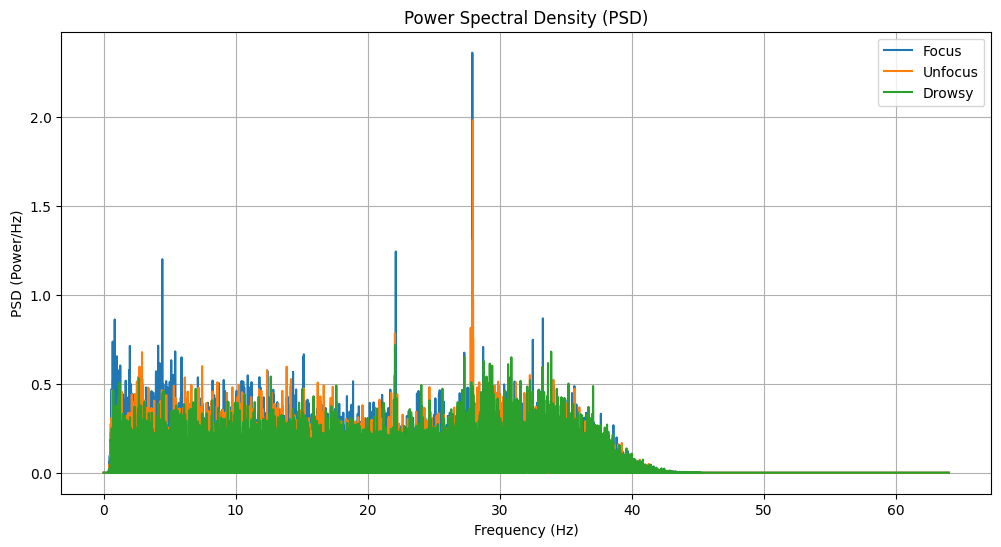

In [43]:
import matplotlib.pyplot as plt

# Plot PSDs for the three datasets
plt.figure(figsize=(12, 6))
plt.plot(focus_freq, focus_psd[:,0], label="Focus")
plt.plot(unfocus_freq, unfocus_psd[:,0], label="Unfocus")
plt.plot(drowsy_freq, drowsy_psd[:,0], label="Drowsy")

# Add labels and legend
plt.title("Power Spectral Density (PSD)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (Power/Hz)")
plt.legend()
plt.grid()
plt.show()


Compute $PSD = power\_spectrum / fs = power / (N*fs) = |X|^2 / (N*fs)$

In [45]:
band_waves = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 100)
}

columns_name = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1',
                    'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']



def get_band_power(freq, psd, band_waves):
    band_power = {}
    for wave in band_waves:
        low, high = band_waves[wave]
        band_data = psd[(freq >= low) & (freq <= high)]
        band_power[wave] = np.mean(band_data)
    return band_power

def create_new_data(freq, psd, band_waves, state):
    new_data = []
    for i in range(14):
        band_power = get_band_power(freq, psd[:,i], band_waves)
        new_data.append(list(band_power.values()))

    new_data = pd.DataFrame(new_data, columns=band_waves.keys())
    new_data['state'] = state
    return new_data

focus_new_data = create_new_data(focus_freq, focus_psd, band_waves, 'focus')
unfocus_new_data = create_new_data(unfocus_freq, unfocus_psd, band_waves, 'unfocus')
drowsy_new_data = create_new_data(drowsy_freq, drowsy_psd, band_waves, 'drowsy')

new_data = pd.concat([focus_new_data, unfocus_new_data, drowsy_new_data], axis=0)
new_data


,delta,theta,alpha,beta,gamma,state
0,0.101701,0.090935,0.084079,0.074158,0.019335,focus
1,42.306463,8.238148,2.190273,0.647278,0.082225,focus
2,9.390160,2.170737,0.901107,0.269975,0.035871,focus
3,0.082624,0.069388,0.069917,0.060750,0.017494,focus
4,0.048135,0.043277,0.044343,0.043216,0.013191,focus
5,8.595877,2.230427,1.208966,0.413022,0.057312,focus
6,56.342898,8.103015,2.152242,0.665975,0.080393,focus
7,176.714769,16.110215,4.629941,1.146188,0.106889,focus
8,19.891909,4.576890,2.211561,0.692531,0.090809,focus
9,0.233418,0.052362,0.033623,0.019356,0.003579,focus
